In [1]:
import albumentations as A
import os
import cv2
import numpy as np
import tifffile
from sklearn.model_selection import train_test_split
from cellpose import models, train, io
import matplotlib.pyplot as plt
from cellpose import plot
from cellpose import utils, io

io.logger_setup()  # Run this to get printing of progress

# Define paths
data_dir = '/root/capsule/data/iGluSnFR_Soma_Annotation'

# Collect all image and mask file paths
image_files = sorted([f for f in os.listdir(data_dir) if f.endswith('_merged.tif')])
mask_files = sorted([f for f in os.listdir(data_dir) if f.endswith('_segmented_v2.tif')])

# Ensure that each image has a corresponding mask
assert len(image_files) == len(mask_files), "Number of images and masks must match."

# Load all images and masks
images = [tifffile.imread(os.path.join(data_dir, img))[:, 1, :, :] for img in image_files]
masks = [tifffile.imread(os.path.join(data_dir, msk)) for msk in mask_files]

# Ensure images and masks have the same number of frames
for img, msk in zip(images, masks):
    assert img.shape[0] == msk.shape[0], "Number of frames in images and masks must match."

# Convert lists to numpy arrays
images = np.concatenate(images, axis=0)
masks = np.concatenate(masks, axis=0)

# Normalize images to 0-1 range
images = images.astype(np.float32) / 255.0

# Convert masks to uint8 if needed
masks_uint8 = masks.astype(np.uint8)

# Define an augmentation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, p=0.5),
], is_check_shapes=False)

augmented_images = []
augmented_masks = []

# Augment each image multiple times
num_augmentations = 5  # Number of times to augment each image

for img, msk in zip(images, masks_uint8):
    for _ in range(num_augmentations):
        # Apply the augmentation pipeline
        transformed = transform(image=img, mask=msk)
        augmented_images.append(transformed['image'])
        augmented_masks.append(transformed['mask'])

# Convert lists to numpy arrays and combine with original data
augmented_images = np.array(augmented_images)
augmented_masks = np.array(augmented_masks)

# Combine original and augmented data
images_combined = np.concatenate((images, augmented_images), axis=0)
masks_combined = np.concatenate((masks_uint8, augmented_masks), axis=0)

# Split data into train+val and test
train_val_images, test_images, train_val_masks, test_masks = train_test_split(
    images_combined, masks_combined, test_size=0.15, random_state=42
)

# Split train+val into train and validation
train_images, val_images, train_masks, val_masks = train_test_split(
    train_val_images, train_val_masks, test_size=0.176, random_state=42  # 0.176 to make validation 15% of total
)

# Initialize Cellpose model
model = models.CellposeModel(gpu=True, model_type='nuclei')

# Train the model with augmented data
train.train_seg(
    model.net,
    train_data=train_images,
    train_labels=train_masks,
    test_data=val_images, 
    test_labels=val_masks,
    channels=[0, 0],  # Adjust channels if needed
    normalize=True,
    weight_decay=1e-4,
    SGD=False,
    learning_rate=0.1,
    n_epochs=1000,
    save_path='/root/capsule/scratch/caleb_cellpose/',
    model_name='custom_cellpose_model.pth'
)

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.15 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


2024-09-14 21:12:23,014 [INFO] WRITING LOG OUTPUT TO /root/.cellpose/run.log
2024-09-14 21:12:23,015 [INFO] 
cellpose version: 	3.0.11 
platform:       	linux 
python version: 	3.10.12 
torch version:  	2.1.0
2024-09-14 21:12:28,884 [INFO] >> nuclei << model set to be used
2024-09-14 21:12:29,807 [INFO] ** TORCH CUDA version installed and working. **
2024-09-14 21:12:29,808 [INFO] >>>> using GPU (CUDA)
2024-09-14 21:12:29,896 [INFO] >>>> loading model /root/.cellpose/models/nucleitorch_0
2024-09-14 21:12:29,942 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-09-14 21:12:29,943 [INFO] computing flows for labels


  6%|▌         | 44/705 [00:03<00:48, 13.67it/s]

2024-09-14 21:12:34,681 [WARNING] empty masks!


  9%|▉         | 62/705 [00:04<00:30, 20.87it/s]

2024-09-14 21:12:35,657 [WARNING] empty masks!


 14%|█▍        | 101/705 [00:06<00:31, 19.13it/s]

2024-09-14 21:12:38,065 [WARNING] empty masks!


 19%|█▉        | 135/705 [00:09<00:38, 14.75it/s]

2024-09-14 21:12:40,424 [WARNING] empty masks!


 20%|██        | 144/705 [00:09<00:28, 19.65it/s]

2024-09-14 21:12:40,976 [WARNING] empty masks!


 24%|██▍       | 169/705 [00:11<00:26, 20.60it/s]

2024-09-14 21:12:42,350 [WARNING] empty masks!


 30%|██▉       | 208/705 [00:13<00:35, 13.82it/s]

2024-09-14 21:12:45,124 [WARNING] empty masks!


 42%|████▏     | 294/705 [00:19<00:22, 17.92it/s]

2024-09-14 21:12:50,169 [WARNING] empty masks!


 42%|████▏     | 298/705 [00:19<00:19, 20.85it/s]

2024-09-14 21:12:50,306 [WARNING] empty masks!


 43%|████▎     | 302/705 [00:19<00:17, 23.07it/s]

2024-09-14 21:12:50,488 [WARNING] empty masks!


 55%|█████▌    | 390/705 [00:24<00:17, 17.60it/s]

2024-09-14 21:12:56,183 [WARNING] empty masks!


 56%|█████▋    | 397/705 [00:25<00:21, 14.12it/s]

2024-09-14 21:12:56,573 [WARNING] empty masks!


 61%|██████    | 430/705 [00:27<00:20, 13.73it/s]

2024-09-14 21:12:58,736 [WARNING] empty masks!


 67%|██████▋   | 473/705 [00:29<00:14, 16.01it/s]

2024-09-14 21:13:01,034 [WARNING] empty masks!


 69%|██████▉   | 485/705 [00:30<00:15, 14.40it/s]

2024-09-14 21:13:01,780 [WARNING] empty masks!


 73%|███████▎  | 515/705 [00:32<00:18, 10.36it/s]

2024-09-14 21:13:03,965 [WARNING] empty masks!


 75%|███████▍  | 527/705 [00:33<00:12, 14.22it/s]

2024-09-14 21:13:04,747 [WARNING] empty masks!


 92%|█████████▏| 646/705 [00:41<00:04, 13.70it/s]

2024-09-14 21:13:12,723 [WARNING] empty masks!


 99%|█████████▉| 699/705 [00:45<00:00, 16.44it/s]

2024-09-14 21:13:16,193 [WARNING] empty masks!


100%|█████████▉| 703/705 [00:45<00:00, 19.94it/s]

2024-09-14 21:13:16,289 [WARNING] empty masks!


100%|██████████| 705/705 [00:45<00:00, 15.59it/s]

2024-09-14 21:13:16,294 [INFO] computing flows for labels



 35%|███▌      | 53/151 [00:02<00:06, 16.10it/s]

2024-09-14 21:13:19,494 [WARNING] empty masks!


 38%|███▊      | 57/151 [00:03<00:04, 19.39it/s]

2024-09-14 21:13:19,773 [WARNING] empty masks!


 48%|████▊     | 72/151 [00:03<00:03, 19.75it/s]

2024-09-14 21:13:20,525 [WARNING] empty masks!


 52%|█████▏    | 79/151 [00:04<00:03, 22.19it/s]

2024-09-14 21:13:20,757 [WARNING] empty masks!


 57%|█████▋    | 86/151 [00:04<00:03, 18.06it/s]

2024-09-14 21:13:21,134 [WARNING] empty masks!


 85%|████████▌ | 129/151 [00:07<00:01, 16.67it/s]

2024-09-14 21:13:23,815 [WARNING] empty masks!


100%|██████████| 151/151 [00:08<00:00, 17.39it/s]

2024-09-14 21:13:25,224 [INFO] >>> computing diameters



  6%|▌         | 44/705 [00:00<00:03, 217.65it/s]/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 151/151 [00:00<00:00, 217.23it/s]

2024-09-14 21:13:29,171 [WARNING] 121 train images with number of masks less than min_train_masks (5), removing from train set
2024-09-14 21:13:29,173 [INFO] >>> using channels [0, 0]
2024-09-14 21:13:29,173 [INFO] >>> normalizing {'lowhigh': None, 'percentile': None, 'normalize': True, 'norm3D': False, 'sharpen_radius': 0, 'smooth_radius': 0, 'tile_norm_blocksize': 0, 'tile_norm_smooth3D': 1, 'invert': False}


2024-09-14 21:13:55,815 [INFO] >>> n_epochs=1000, n_train=584, n_test=151
2024-09-14 21:13:55,816 [INFO] >>> AdamW, learning_rate=0.10000, weight_decay=0.00010
2024-09-14 21:13:56,057 [INFO] >>> saving model to /root/capsule/scratch/caleb_cellpose/models/custom_cellpose_model.pth


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020201/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


2024-09-14 21:14:10,325 [INFO] 0, train_loss=0.4332, test_loss=0.3946, LR=0.0000, time 14.27s
2024-09-14 21:15:08,911 [INFO] 5, train_loss=0.1376, test_loss=0.1461, LR=0.0556, time 72.86s
2024-09-14 21:16:07,304 [INFO] 10, train_loss=0.1131, test_loss=0.1020, LR=0.1000, time 131.25s
2024-09-14 21:18:03,070 [INFO] 20, train_loss=0.0993, test_loss=0.1414, LR=0.1000, time 247.01s
2024-09-14 21:19:58,153 [INFO] 30, train_loss=0.0923, test_loss=0.1060, LR=0.1000, time 362.10s
2024-09-14 21:21:53,480 [INFO] 40, train_loss=0.0898, test_loss=0.0879, LR=0.1000, time 477.42s
2024-09-14 21:23:48,801 [INFO] 50, train_loss=0.0857, test_loss=0.1163, LR=0.1000, time 592.75s
2024-09-14 21:25:44,249 [INFO] 60, train_loss=0.0848, test_loss=0.0877, LR=0.1000, time 708.19s
2024-09-14 21:27:39,680 [INFO] 70, train_loss=0.0862, test_loss=0.0778, LR=0.1000, time 823.62s
2024-09-14 21:29:35,034 [INFO] 80, train_loss=0.0811, test_loss=0.0958, LR=0.1000, time 938.98s
2024-09-14 21:31:30,625 [INFO] 90, train_los

PosixPath('/root/capsule/scratch/caleb_cellpose/models/custom_cellpose_model.pth')

In [2]:
# Load cellpose model
from cellpose import models

def load_cellpose_modelpath(model_path: str,
                            gpu: bool = True) -> models.CellposeModel:

    # load cellpose model
    print('Loading Cellpose Models from folder ...')
    model = models.CellposeModel(gpu=True, pretrained_model=model_path)

    return model

model = load_cellpose_modelpath('/root/capsule/scratch/caleb_cellpose/models/custom_cellpose_model.pth')

import albumentations as A
import os
import cv2
import numpy as np
import tifffile
from sklearn.model_selection import train_test_split
from cellpose import models, train, io
import matplotlib.pyplot as plt
from cellpose import plot
from cellpose import utils, io

io.logger_setup()  # Run this to get printing of progress

# Define paths
data_dir = '/root/capsule/data/iGluSnFR_Soma_Annotation'

# Collect all image and mask file paths
image_files = sorted([f for f in os.listdir(data_dir) if f.endswith('_merged.tif')])
mask_files = sorted([f for f in os.listdir(data_dir) if f.endswith('_segmented_v2.tif')])

# Ensure that each image has a corresponding mask
assert len(image_files) == len(mask_files), "Number of images and masks must match."

# Load all images and masks
images = [tifffile.imread(os.path.join(data_dir, img))[:, 1, :, :] for img in image_files]
masks = [tifffile.imread(os.path.join(data_dir, msk)) for msk in mask_files]

# Ensure images and masks have the same number of frames
for img, msk in zip(images, masks):
    assert img.shape[0] == msk.shape[0], "Number of frames in images and masks must match."

# Convert lists to numpy arrays
images = np.concatenate(images, axis=0)
masks = np.concatenate(masks, axis=0)

# Normalize images to 0-1 range
images = images.astype(np.float32) / 255.0

# Convert masks to uint8 if needed
masks_uint8 = masks.astype(np.uint8)

# Define an augmentation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, p=0.5),
], is_check_shapes=False)

augmented_images = []
augmented_masks = []

# Augment each image multiple times
num_augmentations = 5  # Number of times to augment each image

for img, msk in zip(images, masks_uint8):
    for _ in range(num_augmentations):
        # Apply the augmentation pipeline
        transformed = transform(image=img, mask=msk)
        augmented_images.append(transformed['image'])
        augmented_masks.append(transformed['mask'])

# Convert lists to numpy arrays and combine with original data
augmented_images = np.array(augmented_images)
augmented_masks = np.array(augmented_masks)

# Combine original and augmented data
images_combined = np.concatenate((images, augmented_images), axis=0)
masks_combined = np.concatenate((masks_uint8, augmented_masks), axis=0)

# Split data into train+val and test
train_val_images, test_images, train_val_masks, test_masks = train_test_split(
    images_combined, masks_combined, test_size=0.15, random_state=42
)

# Split train+val into train and validation
train_images, val_images, train_masks, val_masks = train_test_split(
    train_val_images, train_val_masks, test_size=0.176, random_state=42  # 0.176 to make validation 15% of total
)

Loading Cellpose Models from folder ...
2024-09-15 00:26:50,891 [INFO] ** TORCH CUDA version installed and working. **
2024-09-15 00:26:50,892 [INFO] >>>> using GPU (CUDA)
2024-09-15 00:26:50,954 [INFO] >>>> loading model /root/capsule/scratch/caleb_cellpose/models/custom_cellpose_model.pth
2024-09-15 00:26:51,141 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2024-09-15 00:26:51,142 [INFO] >>>> model diam_labels =  45.890 (mean diameter of training ROIs)
2024-09-15 00:26:51,144 [INFO] WRITING LOG OUTPUT TO /root/.cellpose/run.log
2024-09-15 00:26:51,144 [INFO] 
cellpose version: 	3.0.11 
platform:       	linux 
python version: 	3.10.12 
torch version:  	2.1.0


In [3]:
import numpy as np
import pandas as pd
from cellpose import models

# Prepare a list to store the results
results_list = []

# Define a function to calculate metrics
def calculate_metrics(true_mask, masks_pred):
    # Dice Score
    intersection = np.logical_and(true_mask, masks_pred)
    dice_score = 2. * intersection.sum() / (true_mask.sum() + masks_pred.sum())

    # IoU Score
    union = np.logical_or(true_mask, masks_pred)
    iou_score = intersection.sum() / union.sum() if union.sum() > 0 else 0

    # Pixel Accuracy
    pixel_accuracy = np.sum(true_mask == masks_pred) / true_mask.size

    # Number of ROIs
    num_rois_true = np.unique(true_mask).size - 1  # Exclude background
    num_rois_pred = np.unique(masks_pred).size - 1  # Exclude background

    return {
        "Dice Score": dice_score,
        "IoU Score": iou_score,
        "Pixel Accuracy": pixel_accuracy,
        "Number of True ROIs": num_rois_true,
        "Number of Predicted ROIs": num_rois_pred
    }

# Loop through all test images
for i, (image, true_mask) in enumerate(zip(test_images, test_masks)):
    # Evaluate the model on the test image
    results = model.eval(image, channels=[0, 0])
    if len(results) == 3:
        masks_pred, flows, styles = results
    else:
        masks_pred, flows, styles, diams = results

    # Calculate metrics
    metrics = calculate_metrics(true_mask, masks_pred)

    # Append results to the list
    results_list.append({
        'Image_Index': i,
        'Dice_Score': metrics['Dice Score'],
        'IoU_Score': metrics['IoU Score'],
        'Pixel_Accuracy': metrics['Pixel Accuracy'],
        'Number_of_True_ROIs': metrics['Number of True ROIs'],
        'Number_of_Predicted_ROIs': metrics['Number of Predicted ROIs']
    })

# Convert the list of results to a DataFrame
results_df = pd.DataFrame(results_list)

# Save results to a CSV file
results_df.to_csv('/root/capsule/scratch/caleb_cellpose/evaluation_results.csv', index=False)

2024-09-15 00:28:15,018 [INFO] No cell pixels found.


/tmp/ipykernel_5357/185013693.py:12: RuntimeWarning: invalid value encountered in scalar divide
  dice_score = 2. * intersection.sum() / (true_mask.sum() + masks_pred.sum())


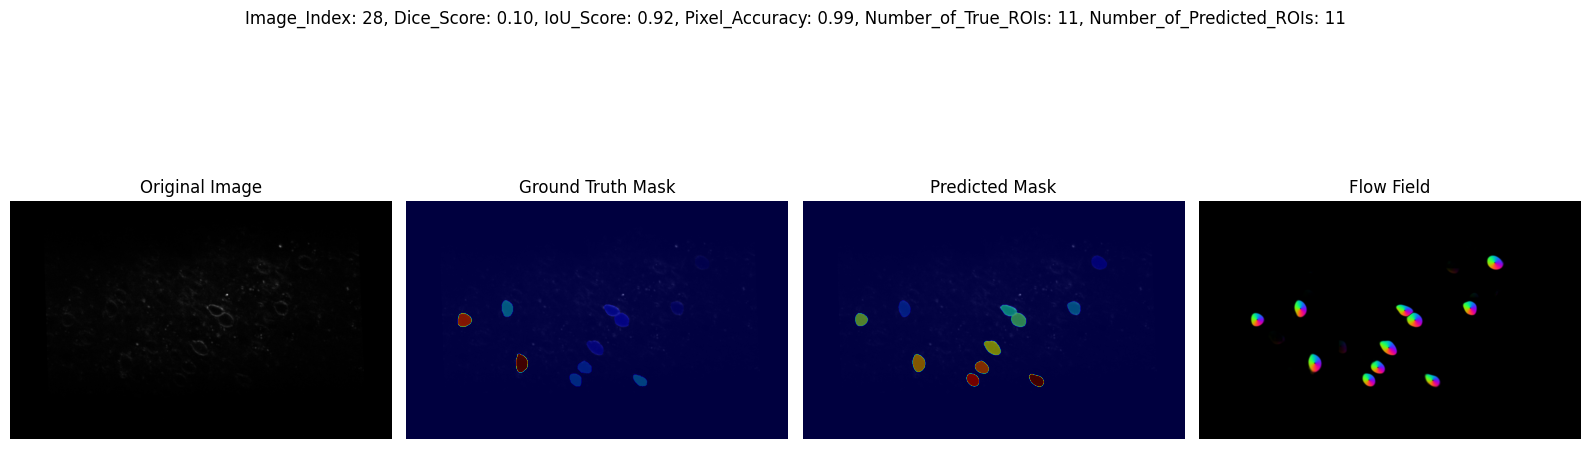

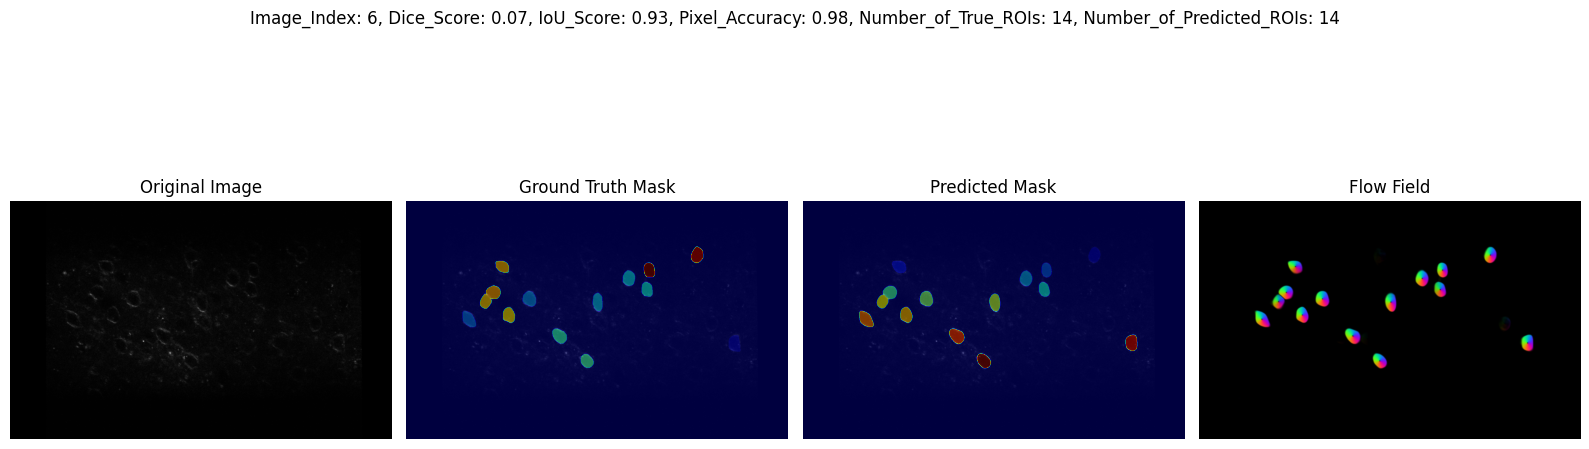

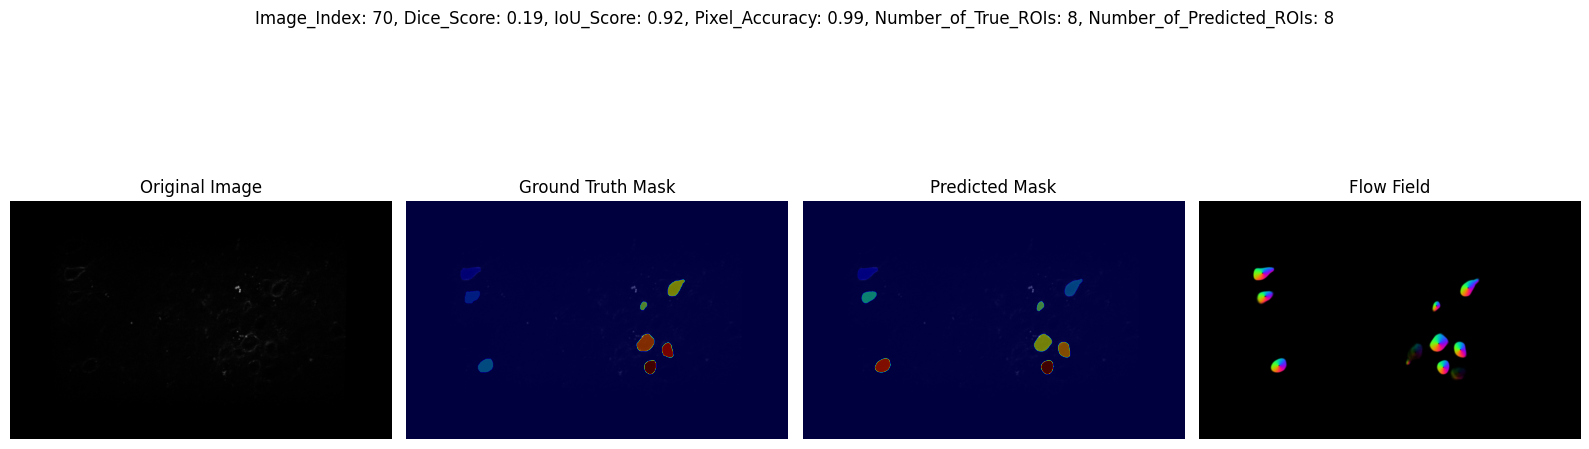

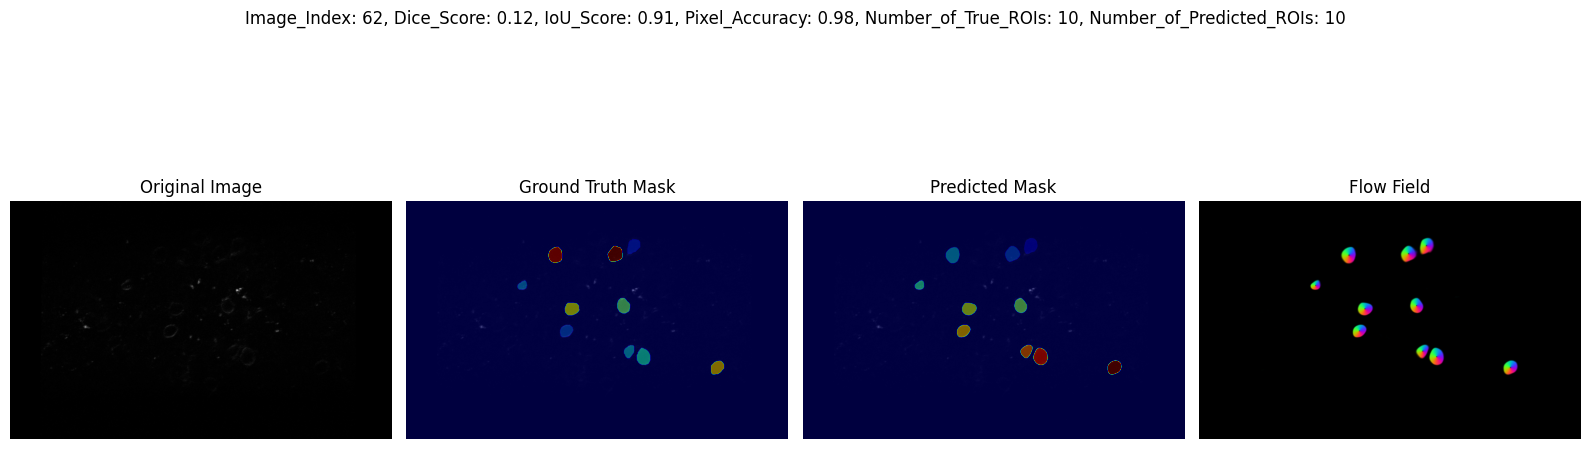

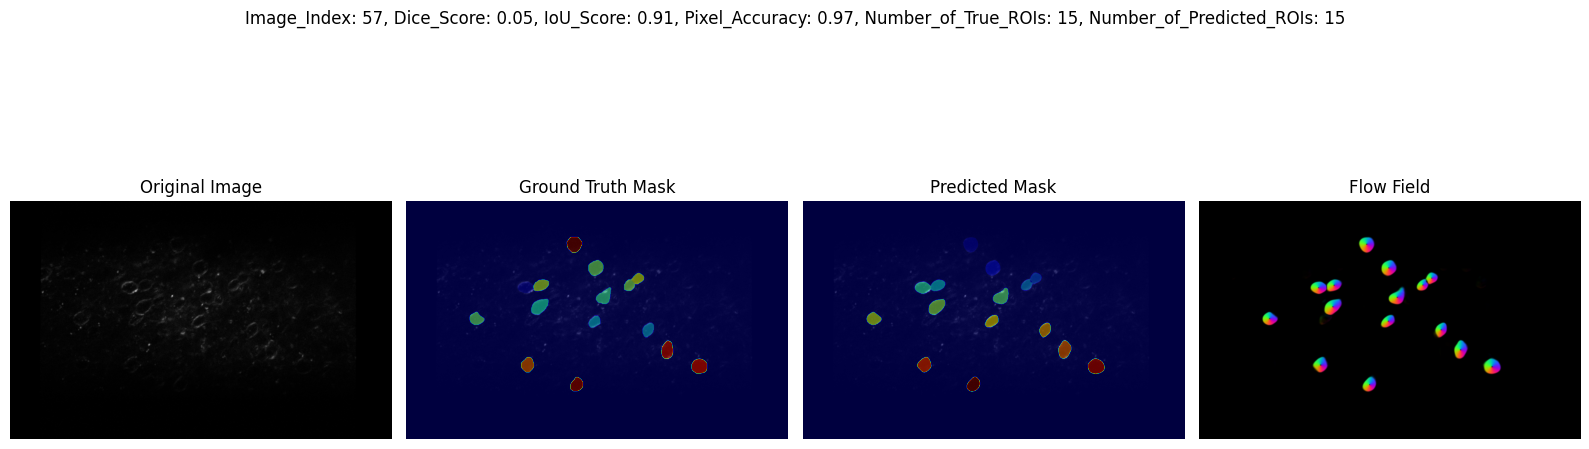

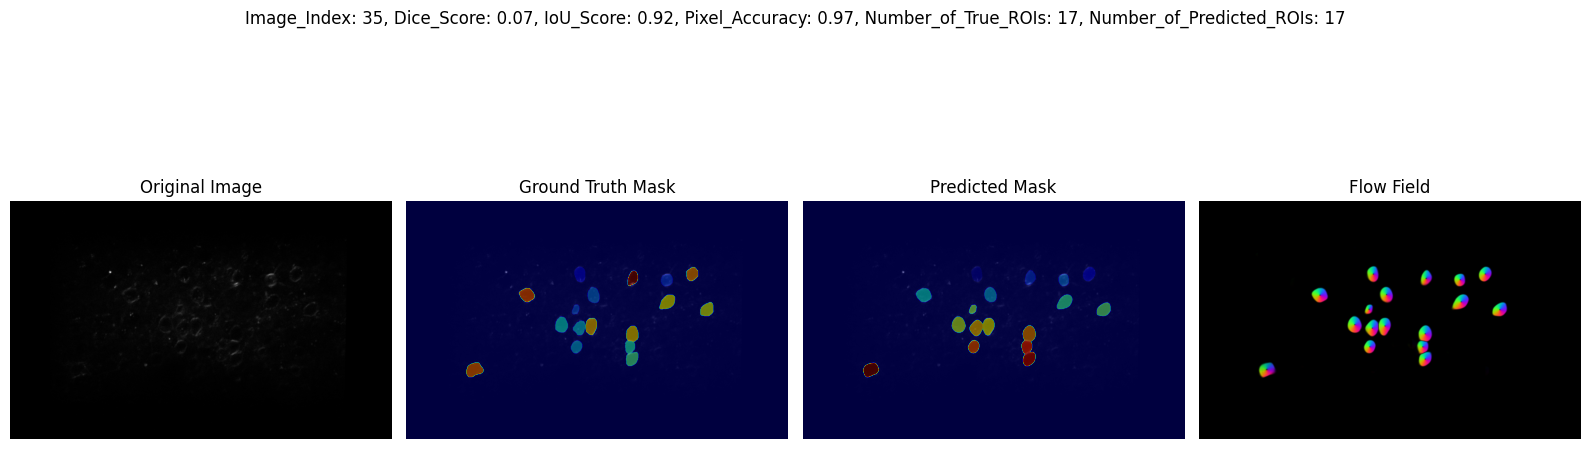

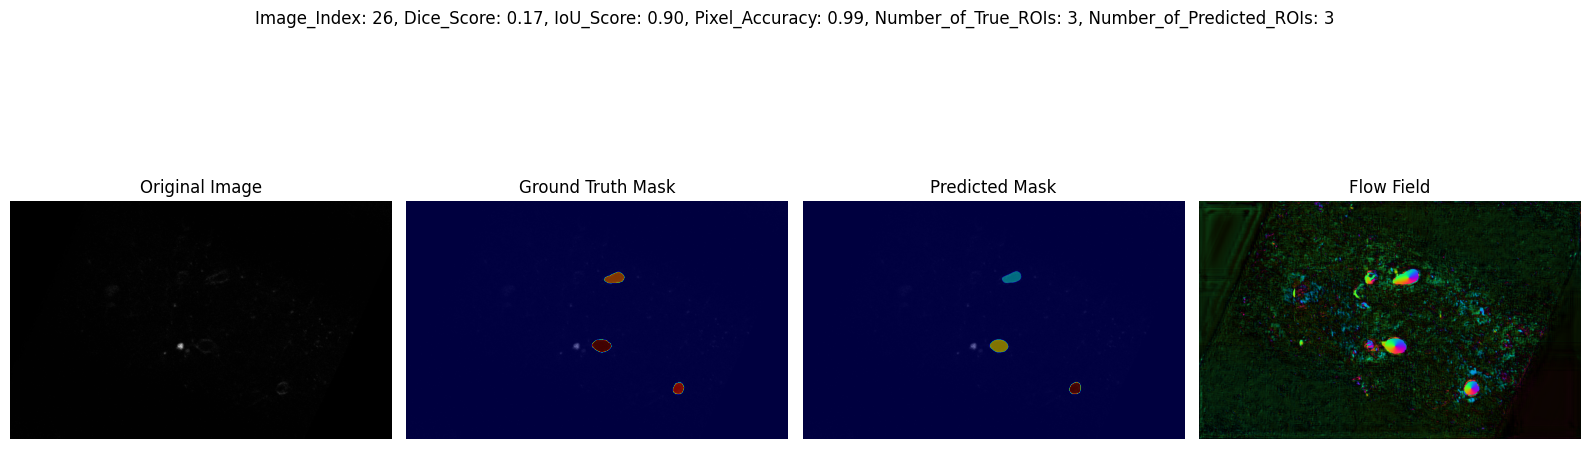

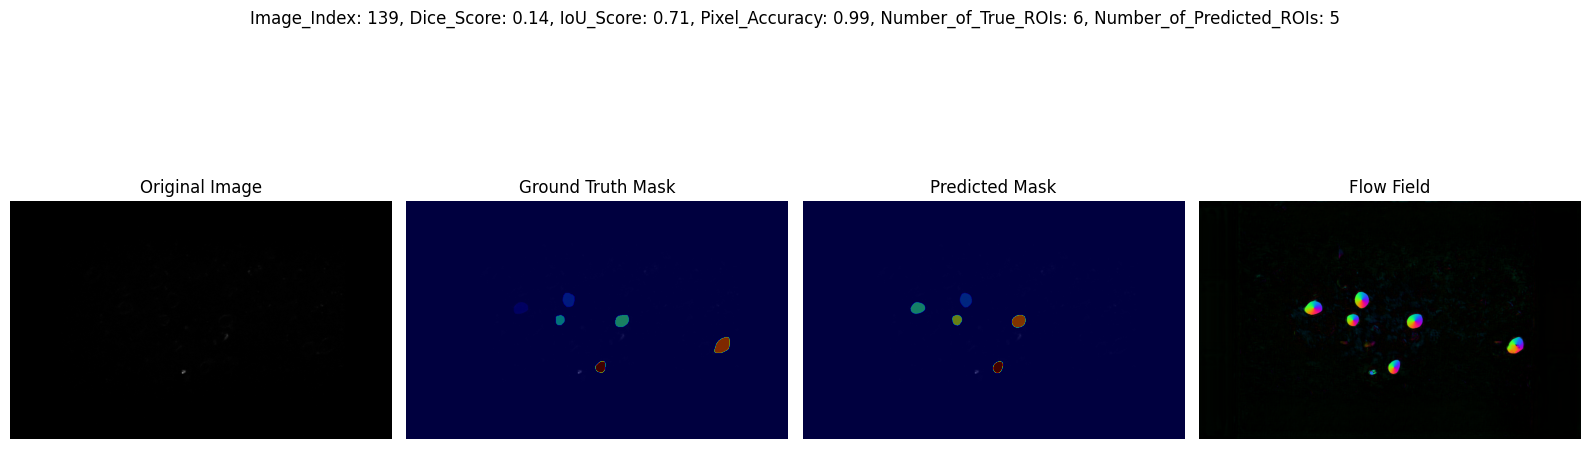

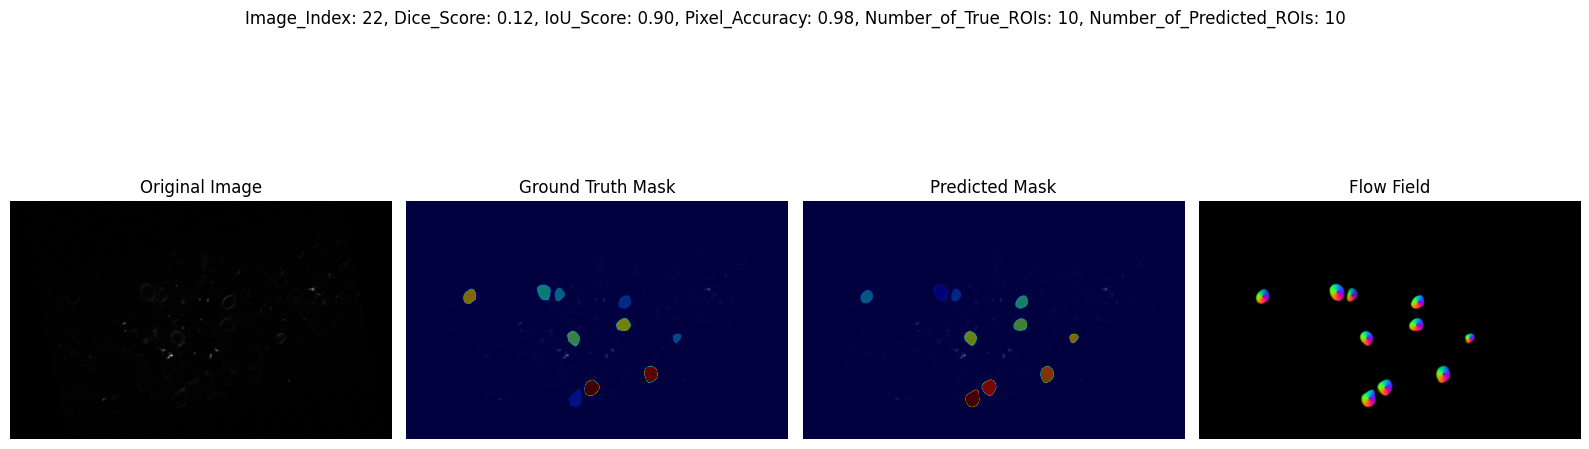

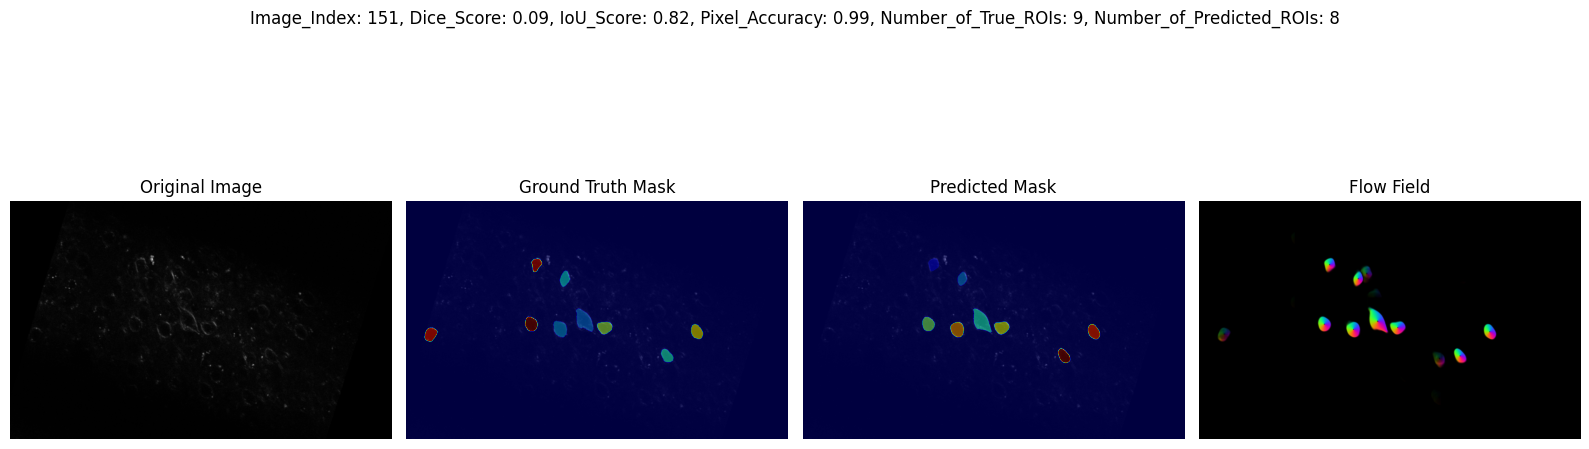

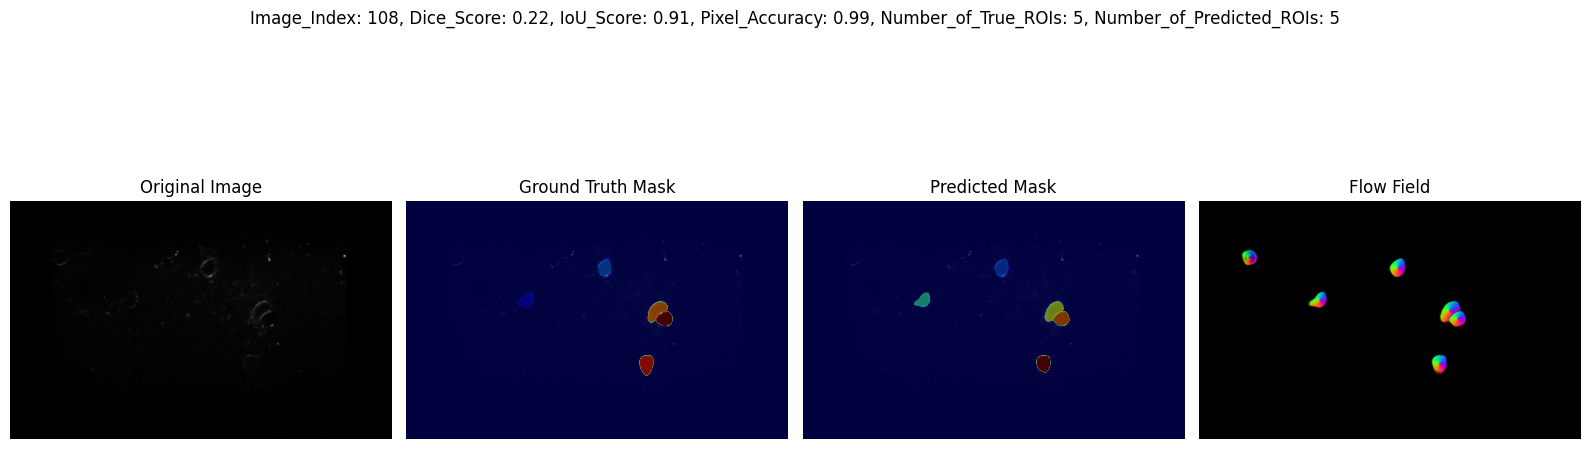

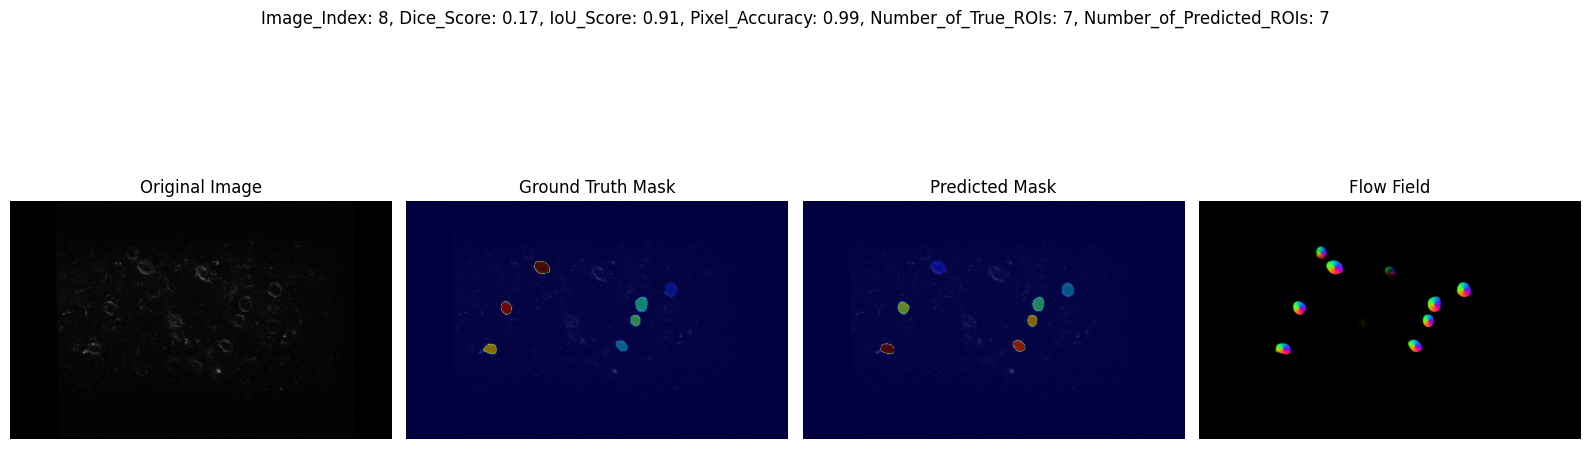

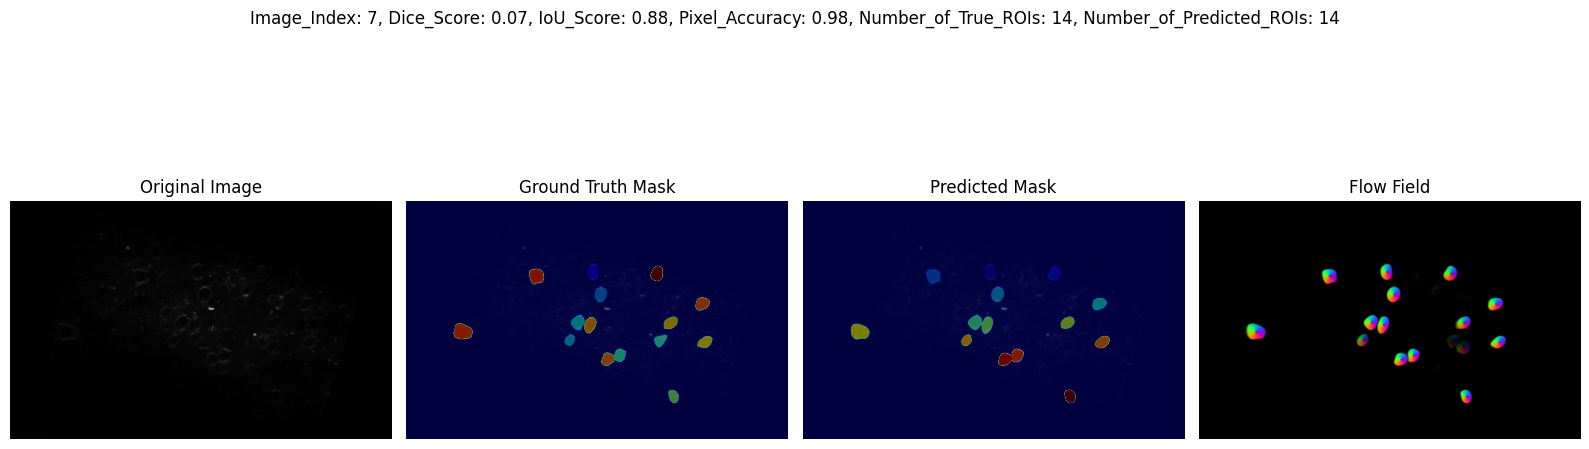

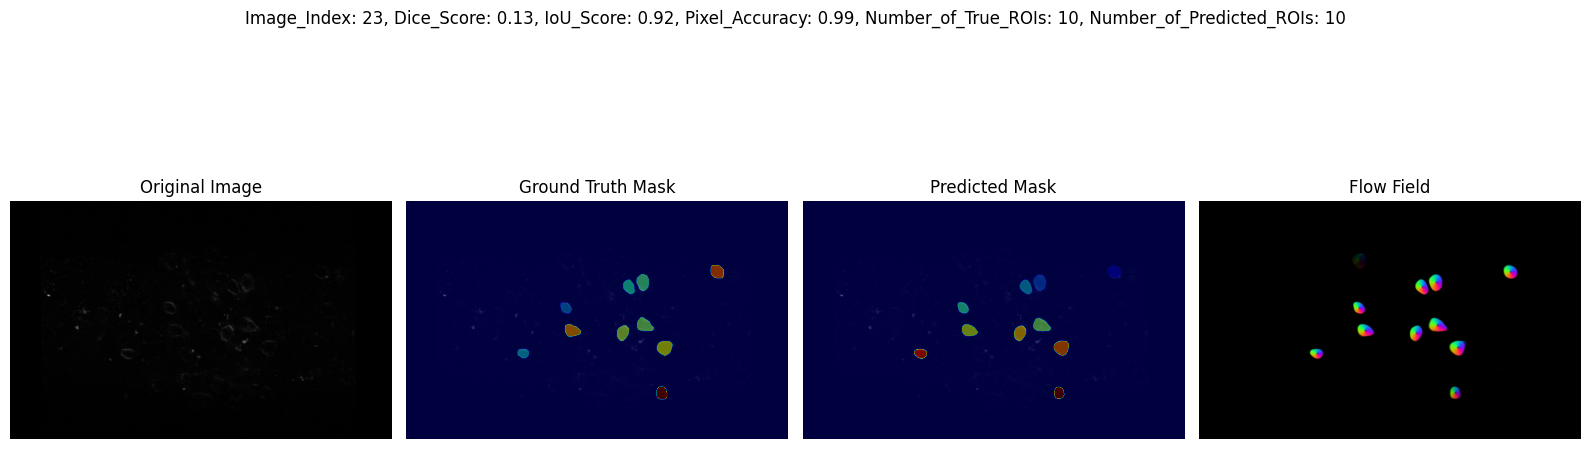

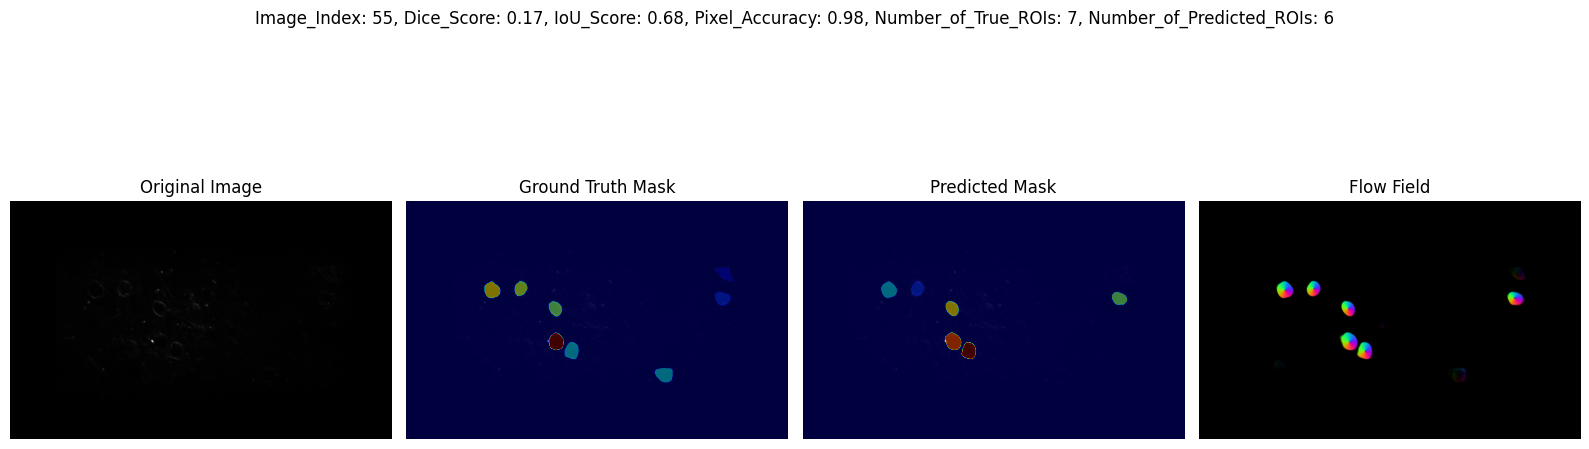

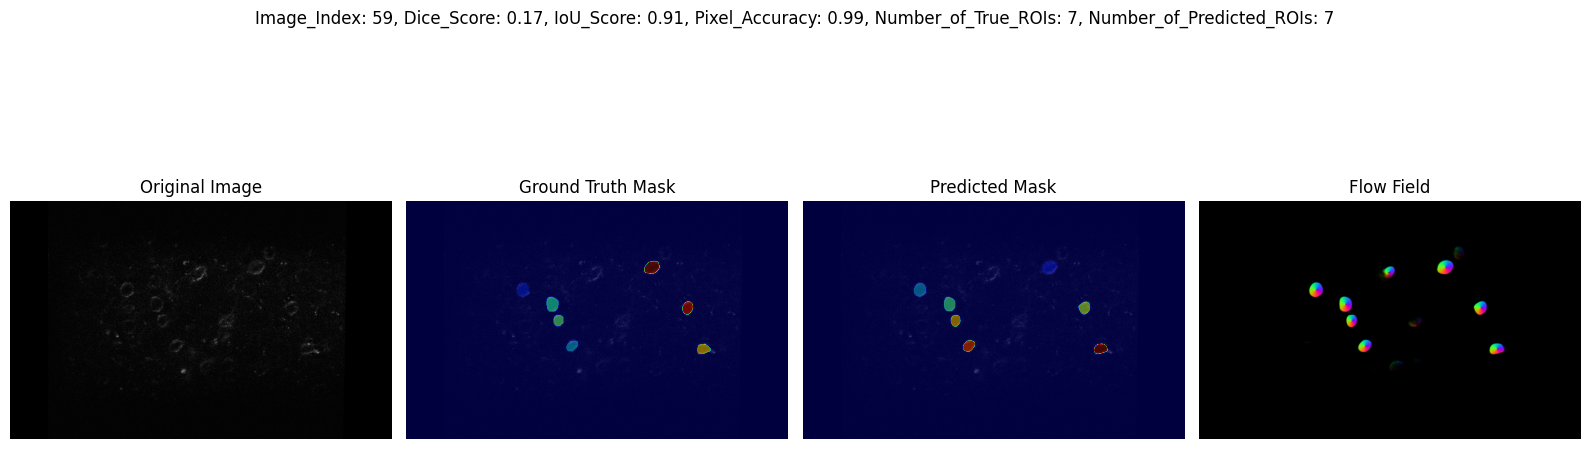

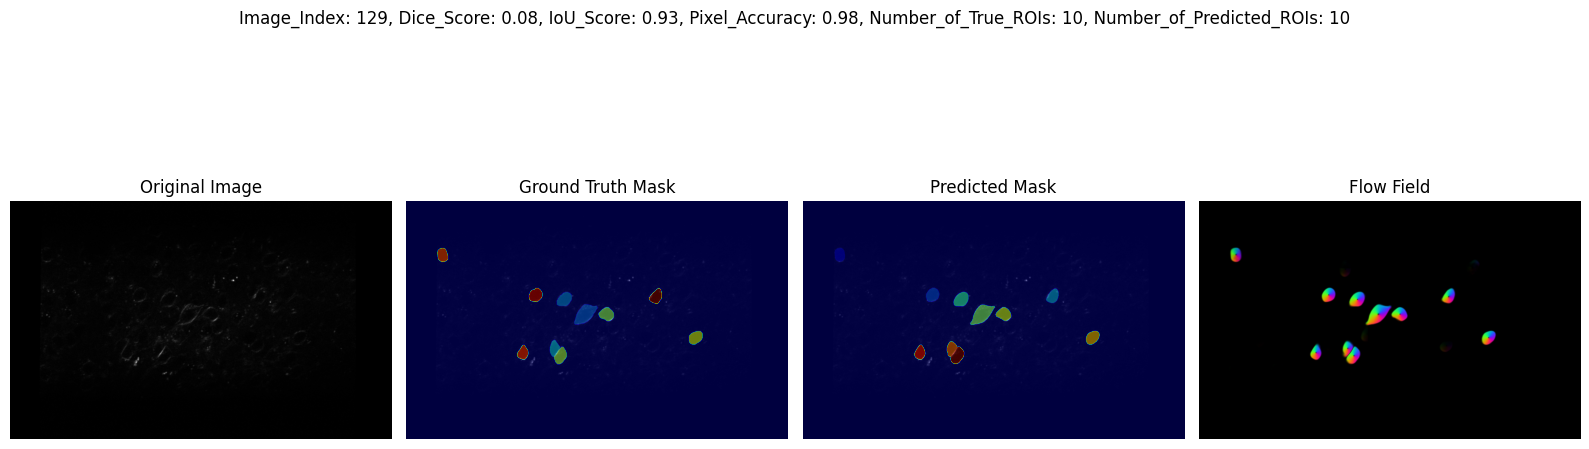

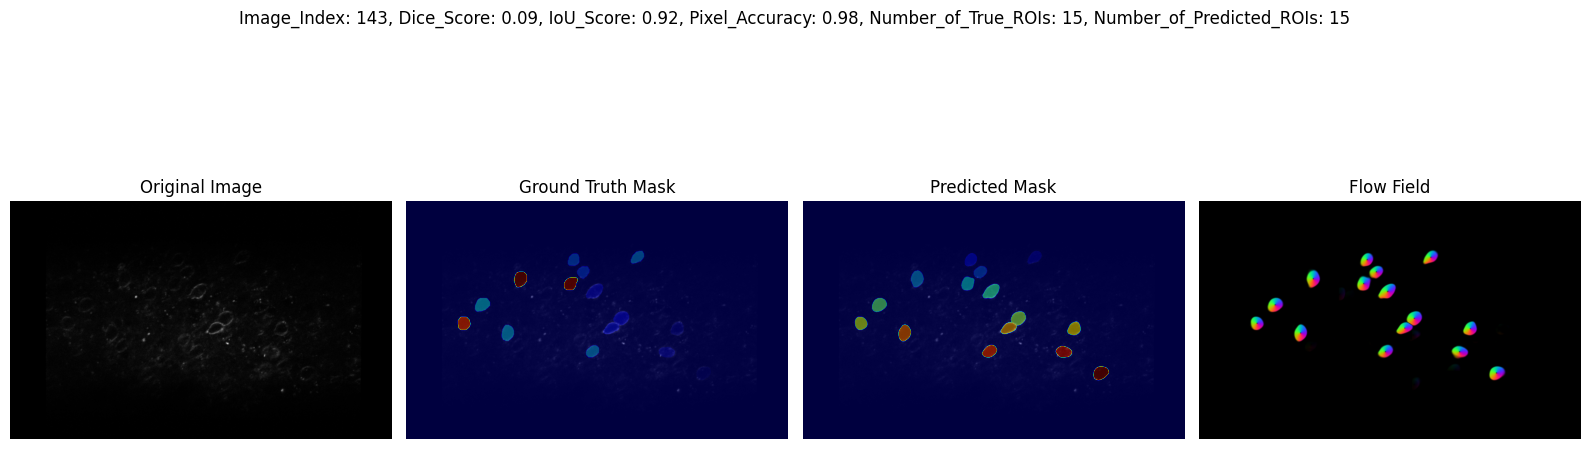

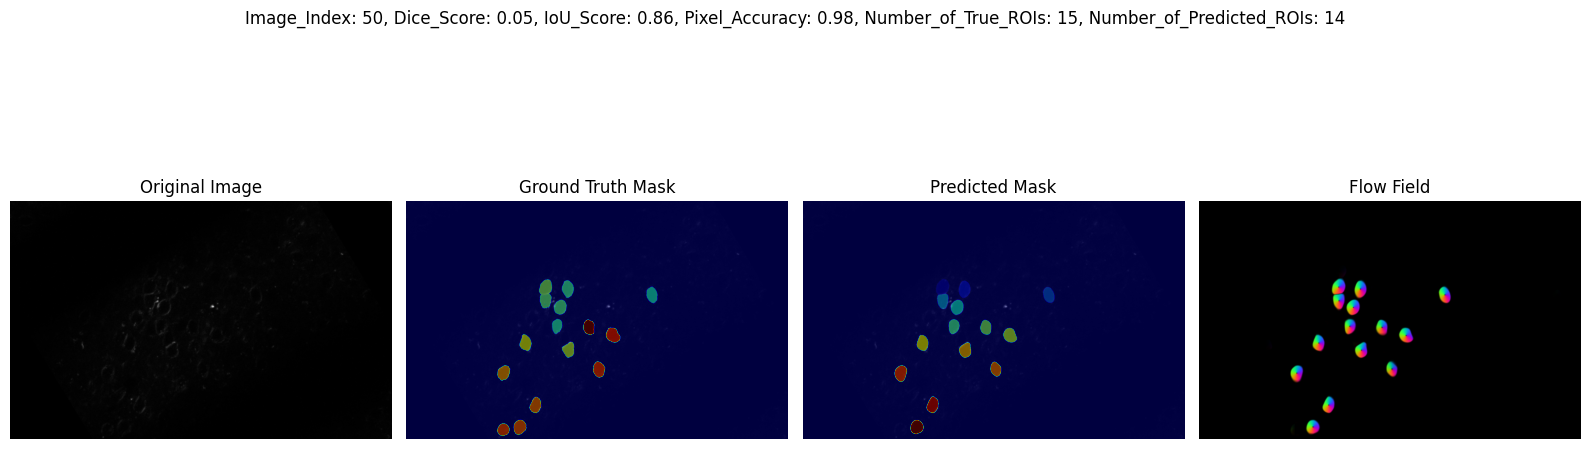

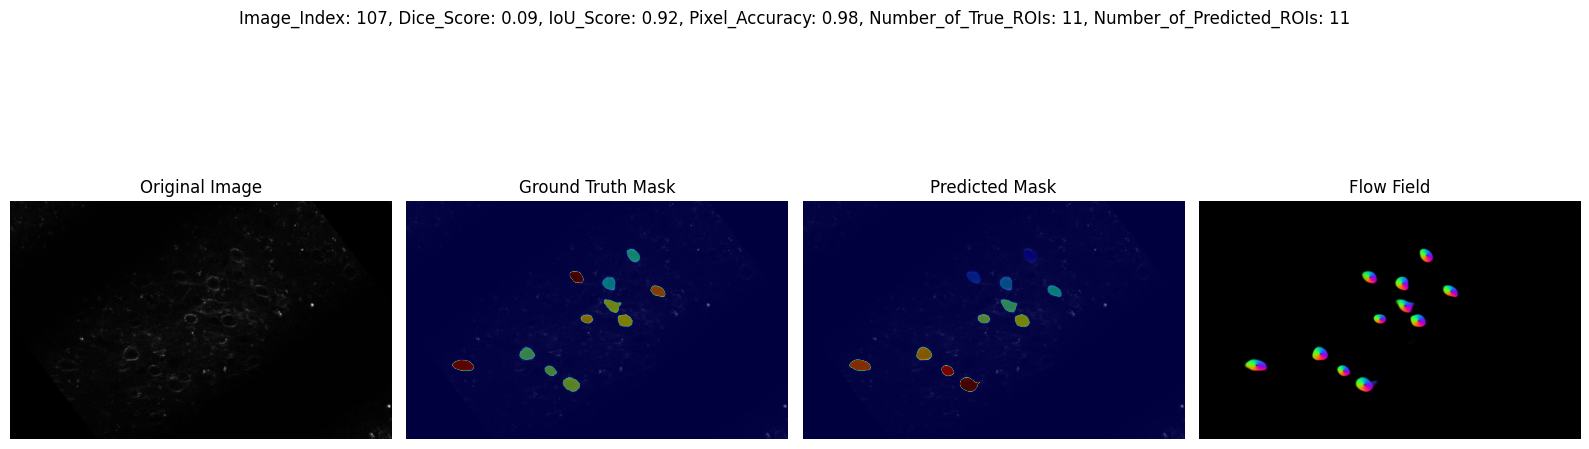

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Set a random seed for reproducibility
random.seed(42)

# Select 20 random indices from the test set
random_indices = random.sample(range(len(test_images)), 20)

# Loop through the selected random indices
for idx in random_indices:
    # Evaluate the model on the test image
    results = model.eval(test_images[idx], channels=[0, 0])
    if len(results) == 3:
        masks_pred, flows, styles = results
    else:
        masks_pred, flows, styles, diams = results

    # Calculate metrics
    metrics = calculate_metrics(test_masks[idx], masks_pred)

    # Construct the title with metrics
    title = (f"Image_Index: {idx}, "
             f"Dice_Score: {metrics['Dice Score']:.2f}, "
             f"IoU_Score: {metrics['IoU Score']:.2f}, "
             f"Pixel_Accuracy: {metrics['Pixel Accuracy']:.2f}, "
             f"Number_of_True_ROIs: {metrics['Number of True ROIs']}, "
             f"Number_of_Predicted_ROIs: {metrics['Number of Predicted ROIs']}")

    # Visualize results for the current test image
    fig, ax = plt.subplots(1, 4, figsize=(16, 6))
    fig.suptitle(title, fontsize=12)

    # Original image
    ax[0].imshow(test_images[idx], cmap='gray')
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # Ground truth mask 
    ax[1].imshow(test_images[idx], cmap='gray')
    ax[1].imshow(test_masks[idx], cmap='jet', alpha=0.5)
    ax[1].set_title('Ground Truth Mask')
    ax[1].axis('off')

    # Predicted mask
    ax[2].imshow(test_images[idx], cmap='gray')
    ax[2].imshow(masks_pred, cmap='jet', alpha=0.5)
    ax[2].set_title('Predicted Mask')
    ax[2].axis('off')

    # Flow visualization
    ax[3].imshow(flows[0], cmap='gray')
    ax[3].set_title('Flow Field')
    ax[3].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the title
    plt.show()